# Abstractive Text Summarization - BiGRU Vanilla

### Importing Basic libraries

In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, GRU, RNN
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
from tensorflow.python.keras.layers import Layer


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 517 kB/s            


### Importing Data

In [4]:
data = pd.read_excel('../input/inshorts-news-data/Inshorts Cleaned Data.xlsx')

In [5]:
data.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
data.head()

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


### Punctuation and Stopword Removal

In [7]:
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    #text = ' '.join([contractions.fix(word) for word in text.split(" ")])    
    
    tokens = [w for w in text.split() if not w in stop_words]
    text = " ".join(tokens)
    text = text.replace("'s",'')
    text = text.replace(".",'')
    text = re.sub(r'\(.*\)','',text)
    text = re.sub(r'[^a-zA-Z0-9. ]',' ',text)
    text = re.sub(r'\.','. ',text)
    text = re.sub(r'\s+', ' ', text)
    return text


### Lemmatization

In [8]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [9]:
data.rename(columns={'Headline': 'headlines', 'Short': 'text'}, inplace=True)

In [10]:
original_text = str(data['text'][0])
original_headline = str(data['headlines'][0])

In [11]:
processed_text = data['text'].apply(preprocess)
data['text'] = processed_text.apply(lemmatize_text)
data['headlines'] = data['headlines'].apply(lambda x : '_START_ '+ x + ' _END_')

for i in range(2):
    print('Summary:', data['headlines'][i],'Text:', data['text'][i], sep='\n')
    print()

Summary:
_START_ 4 ex-bank officials booked for cheating bank of ₹209 crore _END_
Text:
cbi saturday book four former official syndicate bank six other cheat forgery criminal conspiracy cause 209 crore loss state run bank accuse availed home loan credit syndicate bank basis forge fabricate document fund fraudulently transfer company own accuse person

Summary:
_START_ Supreme Court to go paperless in 6 months: CJI _END_
Text:
chief justice js khehar say supreme court go paperless six seven month bid save fund make judiciary eco friendly say apex court collect record electronically low court high court need file hard copy



### Sample Input

In [12]:
print("\nORIGINAL")
print(original_text)
print(original_headline)

print("\nREGEX CLEANING AND STOPWORD REMOVAL:")
print(processed_text[0])
# print(brief_cleaned_summary[0])

print("\nLEMMATIZATION + START AND END TOKEN")
print(data['text'][0])
print(data['headlines'][0])


ORIGINAL
The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.
4 ex-bank officials booked for cheating bank of ₹209 crore

REGEX CLEANING AND STOPWORD REMOVAL:
cbi saturday booked four former officials syndicate bank six others cheating forgery criminal conspiracy causing 209 crore loss state run bank accused availed home loans credit syndicate bank basis forged fabricated documents funds fraudulently transferred companies owned accused persons

LEMMATIZATION + START AND END TOKEN
cbi saturday book four former official syndicate bank six other cheat forgery criminal conspiracy cause 209 crore loss state run bank accuse availed home loan credit syndicate bank basis 

In [13]:
headlines_length = [len(x.split()) for x in data.headlines]
text_length = [len(x.split()) for x in data.text]

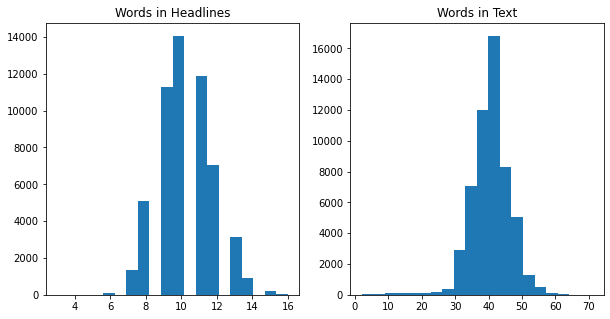

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.hist(headlines_length, bins = 20)
ax2.hist(text_length, bins = 20)

ax1.title.set_text("Words in Headlines")
ax2.title.set_text("Words in Text")
plt.show()

In [15]:
numWords = 62369

### Splitting Data

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['headlines'], test_size = 0.2, random_state = 20)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size = 0.5, random_state = 20)

In [17]:
max_length_x = max(text_length)
max_length_y = max(headlines_length)

### Tokenization

In [18]:
x_t = Tokenizer()
x_t.fit_on_texts(data['text'] + data['headlines'])
x_vocab_size = len(x_t.word_index) + 1

encoded_xtrain = x_t.texts_to_sequences(X_train)
encoded_xval = x_t.texts_to_sequences(X_val)
encoded_xtest = x_t.texts_to_sequences(X_test)

padded_xtrain = pad_sequences(encoded_xtrain, maxlen=max_length_x, padding='post')
padded_xval = pad_sequences(encoded_xval, maxlen=max_length_x, padding='post')
padded_xtest = pad_sequences(encoded_xtest, maxlen=max_length_x, padding='post')

In [19]:
y_t = Tokenizer()
y_t.fit_on_texts(data['headlines'])
y_vocab_size = len(y_t.word_index) + 1

encoded_ytrain = y_t.texts_to_sequences(y_train)
encoded_yval = y_t.texts_to_sequences(y_val)
encoded_ytest = y_t.texts_to_sequences(y_test)

padded_ytrain = pad_sequences(encoded_ytrain, maxlen=max_length_y, padding='post')
padded_yval = pad_sequences(encoded_yval, maxlen=max_length_y, padding='post')
padded_ytest = pad_sequences(encoded_ytest, maxlen=max_length_y, padding='post')

### Building Model

In [21]:
latent_dim=80

K.clear_session() 

encoder_inputs = Input(shape=(max_length_x,)) 
enc_emb = Embedding(x_vocab_size, 100,input_length=max_length_x)(encoder_inputs) 

encoder_lstm1 = Bidirectional(GRU(latent_dim,return_sequences=True,return_state=True) )
encoder_output1, state_h1, state_b1 = encoder_lstm1(enc_emb) 
encoder_lstm2 = Bidirectional(GRU(latent_dim,return_sequences=True,return_state=True) )
encoder_output2, state_h2,  state_b2 = encoder_lstm2(encoder_output1) 
encoder_lstm3 = Bidirectional(GRU(latent_dim, return_state=True, return_sequences=True) )
encoder_outputs3, state_h3, state_b3= encoder_lstm3(encoder_output2)
encoder_lstm4 = Bidirectional(GRU(latent_dim,return_sequences=True,return_state=True) )
encoder_outputs, state_h, state_b4 = encoder_lstm4(encoder_outputs3) 

encoder_states = [state_h,state_b4]
# Decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_vocab_size, 100,input_length=max_length_x) 
dec_emb = dec_emb_layer(decoder_inputs) 

decoder_lstm1 = GRU(80, return_sequences=True, return_state=True) 
decoder_outputs1,decoder_fwd_state1 = decoder_lstm1(dec_emb,initial_state=[state_h]) 

decoder_lstm2 = GRU(80, return_sequences=True, return_state=True) 
decoder_outputs2,decoder_fwd_state2 = decoder_lstm2(decoder_outputs1,initial_state=[decoder_fwd_state1]) 

decoder_lstm3 = GRU(80, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state = decoder_lstm3(decoder_outputs2,initial_state=[decoder_fwd_state2]) 

decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_outputs) 

model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
print(model.summary())

2022-02-16 07:19:40.222519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 07:19:40.223731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 07:19:40.224384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 07:19:40.225148: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 71)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 71, 100)      6984400     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 71, 160), (N 87360       embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 71, 160), (N 116160      bidirectional[0][0]              
______________________________________________________________________________________________

In [22]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
checkpoint_filepath = './model.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True, save_freq = "epoch")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
history=model.fit(
    [padded_xtrain,padded_ytrain[:,:-1]], 
    padded_ytrain.reshape(padded_ytrain.shape[0],padded_ytrain.shape[1], 1)[:,1:], 
    epochs=50,
    batch_size=512, 
    validation_data=([padded_xval,padded_yval[:,:-1]], padded_yval.reshape(padded_yval.shape[0],padded_yval.shape[1], 1)[:,1:]), 
    callbacks=[model_checkpoint_callback])

2022-02-16 07:19:49.932184: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-02-16 07:20:02.346805: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


87/87 [==============================] - 33s 221ms/step - loss: 6.6274 - val_loss: 5.3798
Epoch 2/50
87/87 [==============================] - 16s 188ms/step - loss: 5.1423 - val_loss: 4.9810
Epoch 3/50
87/87 [==============================] - 16s 189ms/step - loss: 4.8462 - val_loss: 4.7970
Epoch 4/50
87/87 [==============================] - 16s 189ms/step - loss: 4.7064 - val_loss: 4.7205
Epoch 5/50
87/87 [==============================] - 16s 189ms/step - loss: 4.6328 - val_loss: 4.6671
Epoch 6/50
87/87 [==============================] - 16s 189ms/step - loss: 4.5641 - val_loss: 4.5887
Epoch 7/50
87/87 [==============================] - 16s 189ms/step - loss: 4.4860 - val_loss: 4.5537
Epoch 8/50
87/87 [==============================] - 16s 189ms/step - loss: 4.4048 - val_loss: 4.4560
Epoch 9/50
87/87 [==============================] - 16s 190ms/step - loss: 4.3300 - val_loss: 4.3975
Epoch 10/50
87/87 [==============================] - 17s 190ms/step - loss: 4.2647 - val_loss: 4.3467


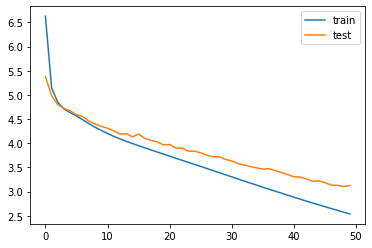

In [23]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [24]:
model.save_weights("final_weights.h5")

### Inference

In [25]:
reverse_target_word_index = y_t.index_word 
reverse_source_word_index = x_t.index_word 
target_word_index = y_t.word_index

In [26]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h])
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_length_x,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs3, state_h3, state_b3 = decoder_lstm1(dec_emb2, initial_state=[decoder_state_input_h])

decoder_outputs4, state_h4, state_b4 = decoder_lstm2(decoder_outputs3, initial_state=[state_h3])
decoder_outputs5, state_h5, state_b5 = decoder_lstm3(decoder_outputs4, initial_state=[state_h4])

decoder_outputs5 = decoder_dense(decoder_outputs5)

decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h],
[decoder_outputs5] + [state_h5, state_b5])

In [27]:
def decode_sequence(input_seq):
    input_seq= input_seq.reshape(1,max_length_x)
    e_out, e_h = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq] + [e_out, e_h])

        sampled_token_index = np.argmax(output_tokens[0, -1, :]) 
        sampled_token = reverse_target_word_index[sampled_token_index]
  
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
 
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_length_y-1)):
                stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h = h

    return decoded_sentence

In [28]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [29]:
print("Review:",seq2text(padded_xtest[3]))
print("Original summary:",seq2summary(padded_ytest[3]))
print("Predicted summary:",decode_sequence(padded_xtest[3]))


Review: actor tiger shroff feature cover february issue man 39 s luxury lifestyle magazine 39 mansworld 39 see outfit italian luxury menswear brand canali pair watch italian luxury good brand bulgari cover story feature actor title 39 tiger shroff want perfectionist 39 
Original summary: tiger shroff features on feb cover of 39 mansworld 39 magazine 
Predicted summary:  tiger shroff features on cover of 39 vogue 39 magazine



In [30]:
print("Review:",seq2text(padded_xtest[17]))
print("Original summary:",seq2summary(padded_ytest[17]))
print("Predicted summary:",decode_sequence(padded_xtest[17]))


Review: portuguese footballer cristiano ronaldo world s highest pay sportsman 88 million yearly earning per forbes 100 list top earn celebrity worldwide argentina barcelona forward lionel messi second list yearly earning 815 million notably indian sportsperson cricketer feature list 
Original summary: ronaldo world’s highest earning forbes 
Predicted summary:  ronaldo most valuable athlete in world 39 s



In [31]:
print("Review:",seq2text(padded_xtest[42]))
print("Original summary:",seq2summary(padded_ytest[42]))
print("Predicted summary:",decode_sequence(padded_xtest[42]))


Review: north korea monday threaten launch pre nuclear strike justice washington seoul come reaction annual united state south korea military drill start expect take place till april 34 provocation reduce sea flame ashe 34 push button north korea say 
Original summary: n korea threatens nuke attacks on us s korea 
Predicted summary:  n korea threatens to stop nuclear weapons



### Evaluation

In [32]:
def BLEU_Score(y_test, y_pred):
    references = [[seq2summary(y_test).split(" ")]]
    candidates = [decode_sequence(y_pred.reshape(1,max_length_x)).split(" ")]
    return corpus_bleu(references, candidates)

In [34]:
from nltk.translate.bleu_score import corpus_bleu
scores=[]
for i in range(0,500):
    scores.append(BLEU_Score(padded_ytest[i],padded_xtest[i]))
    
print(np.mean(scores))

0.5748590209852851
